# データ空間の回転系手法まとめ（PCA・因子分析・ICA）

本ノートブックでは、多変量データの次元削減や構造抽出において「回転（Rotation）」や「基底変換」の概念が重要となる3つの主要な手法、**主成分分析 (PCA)**、**因子分析 (Factor Analysis)**、**独立成分分析 (ICA)** について、その理論的背景と実際の挙動を比較します。

## 目的と位置づけ
- **PCA（主成分分析）**：分散を最大化する直交基底を見つけ、次元削減・可視化・ノイズ除去に使う。
- **因子分析（FA）**：観測変数を少数の潜在因子＋誤差で説明するモデル。説明可能性と因子解釈が目的。
- **ICA（独立成分分析）**：観測信号を統計的に独立な成分に分解する。混合信号の分離や特徴抽出に使う。

## 直感的な違い（ざっくり）
| 手法 | 目的 | 仮定 | 得られる成分 | 典型用途 |
|---|---|---|---|---|
| **PCA** | 分散最大化 | 線形・直交・ガウス分布（暗黙） | 直交な主成分（無相関） | 次元削減、可視化、前処理 |
| **因子分析** | 潜在因子の推定 | 線形・誤差分離・因子負荷 | 潜在因子（回転により解釈容易化） | 心理尺度、アンケート分析、概念抽出 |
| **ICA** | 独立成分の抽出 | 線形・非ガウス・独立 | 独立成分（非直交可） | 信号分離（カクテルパーティー問題）、脳波解析 |

## 何が「回転」か
- **PCA**: データの分散が最大になる方向へ座標軸を**直交回転**させます。
- **因子分析**: 抽出された因子の解釈を容易にするため、バリマックス回転（Varimax）などの**回転**操作を行うことが標準的です。
- **ICA**: 信号の独立性が最大になるような座標系（必ずしも直交しない）を探す操作であり、これも広義の**回転**とスケーリングを含みます。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from scipy import signal
import ipywidgets as widgets
from IPython.display import display, clear_output

# 日本語フォントの設定
import matplotlib.font_manager as fm
font_path = '../fonts/ipaexg.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'IPAexGothic'

%matplotlib inline

## 1. データの生成：混合された信号

各手法の違いを明確にするため、古典的な「カクテルパーティー問題」のような状況をシミュレーションします。
ここでは、統計的性質の異なる2つの原信号を生成し、それを線形混合します。

1. **正弦波 (Sine Wave)**: ガウス分布に近い、周期的な信号。
2. **ノコギリ波 (Sawtooth Wave)**: 非ガウス性が強い信号。

これらを混合行列 $A$ で混ぜ合わせ、さらに観測ノイズを加えます。

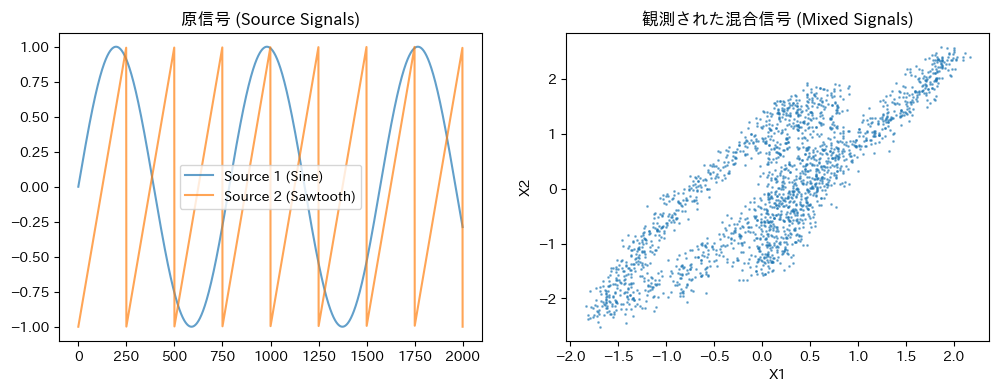

In [2]:
def generate_data(n_samples=2000, noise_level=0.1):
    np.random.seed(0)
    time = np.linspace(0, 8, n_samples)

    # 原信号の生成
    s1 = np.sin(2 * time)  # 正弦波
    s2 = signal.sawtooth(2 * np.pi * time)  # ノコギリ波

    S = np.c_[s1, s2]
    
    # 混合行列 (Mixing Matrix)
    A = np.array([[1, 1], [0.5, 2]])
    
    # 信号の混合
    X = np.dot(S, A.T)
    
    # ノイズの付加
    X += noise_level * np.random.normal(size=X.shape)
    
    return X, S, A

# データの生成と可視化
X, S, A_true = generate_data()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(S[:, 0], alpha=0.7, label='Source 1 (Sine)')
axes[0].plot(S[:, 1], alpha=0.7, label='Source 2 (Sawtooth)')
axes[0].set_title("原信号 (Source Signals)")
axes[0].legend()

axes[1].scatter(X[:, 0], X[:, 1], alpha=0.5, s=1)
axes[1].set_title("観測された混合信号 (Mixed Signals)")
axes[1].set_xlabel("X1")
axes[1].set_ylabel("X2")
plt.show()

右側の散布図を見ると、2つの信号が混ざり合い、相関を持っていることがわかります。このデータに対して各手法を適用し、どのように「元の構造」を復元しようとするかを見ていきます。

## 2. 主成分分析 (PCA)

PCAはデータの**分散が最大になる方向**（第1主成分）を探し、次にその方向と直交する方向の中で分散が最大になる方向（第2主成分）を探します。

### 特徴
- 軸は必ず直交します。
- データのガウス分布性を仮定（あるいは2次の統計量である分散のみに着目）しています。
- **結果**: 混合信号の分散が大きい方向を見つけますが、非ガウス的な構造（ノコギリ波の形状など）を区別して取り出すことは保証されません。

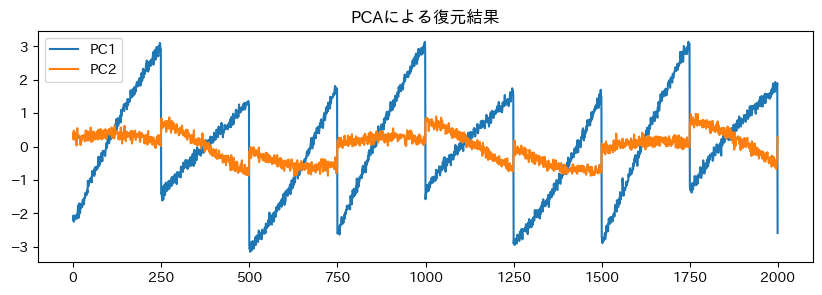

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 結果のプロット
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(X_pca[:, 0], label='PC1')
ax.plot(X_pca[:, 1], label='PC2')
ax.set_title("PCAによる復元結果")
ax.legend()
plt.show()

## 3. 独立成分分析 (ICA)

ICAは、元の信号が**統計的に独立**であり、かつ**非ガウス分布**に従うと仮定します。PCAのように分散（2次の統計量）だけでなく、尖度などの高次の統計量を利用して、信号の独立性を最大化する方向（分離行列）を探します。

### 特徴
- 軸は直交するとは限りません。
- 非ガウス性の強い信号（音声、エッジの効いた画像など）の分離に強力です。
- **結果**: 原信号の「正弦波」と「ノコギリ波」をきれいに分離できることが期待されます。

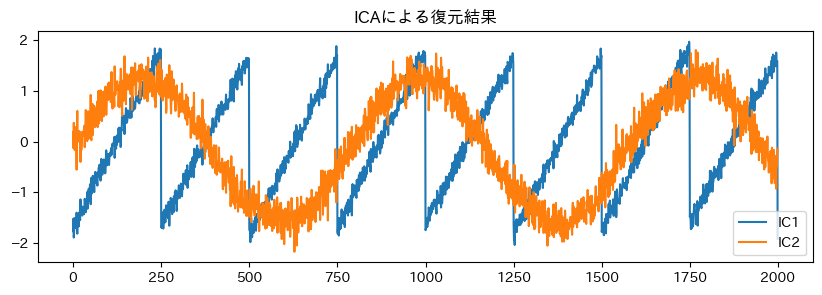

In [4]:
ica = FastICA(n_components=2, random_state=0)
X_ica = ica.fit_transform(X)

# 結果のプロット
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(X_ica[:, 0], label='IC1')
ax.plot(X_ica[:, 1], label='IC2')
ax.set_title("ICAによる復元結果")
ax.legend()
plt.show()

## 4. 因子分析 (Factor Analysis)

因子分析は、観測変数の背後に潜む**共通因子**と、変数独自の**独自因子（ノイズ）**をモデル化します。PCAと似ていますが、誤差項（ノイズ）を明示的に扱う点が異なります。

また、因子分析では**「因子の回転」**が重要なステップです。初期解（PCAに近いもの）を求めた後、因子の解釈を容易にするために軸を回転させます。代表的なのが**バリマックス回転（Varimax Rotation）**で、これは各因子の負荷量（寄与度）の分散を最大化し、各変数が特定の因子に強く紐づくようにします。

### 特徴
- ノイズのモデリングが含まれるため、S/N比が悪いデータでPCAよりロバストな場合があります。
- 回転を行うことで、データの軸に沿った解釈（軸合わせ）を行います。

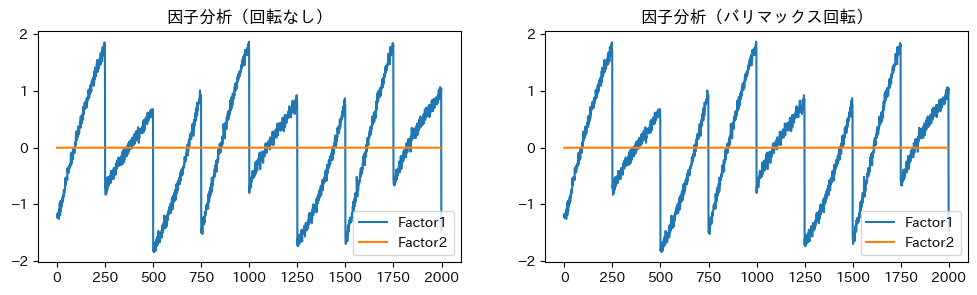

In [5]:
# 回転なし
fa = FactorAnalysis(n_components=2, rotation=None, random_state=0)
X_fa = fa.fit_transform(X)

# バリマックス回転あり
fa_varimax = FactorAnalysis(n_components=2, rotation='varimax', random_state=0)
X_fa_v = fa_varimax.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(X_fa[:, 0], label='Factor1')
axes[0].plot(X_fa[:, 1], label='Factor2')
axes[0].set_title("因子分析（回転なし）")
axes[0].legend()

axes[1].plot(X_fa_v[:, 0], label='Factor1')
axes[1].plot(X_fa_v[:, 1], label='Factor2')
axes[1].set_title("因子分析（バリマックス回転）")
axes[1].legend()
plt.show()

## 5. インタラクティブ比較実験

ここでは、混合の度合いやノイズレベルを変更して、3つの手法がどのように振る舞うかをリアルタイムに比較します。

- **Mixing**: 混合行列の非対角成分の大きさ。0に近いほど元の信号がそのまま観測され、大きいほど強く混ざります。
- **Noise**: 観測ノイズの大きさ。

**観察ポイント**:
- 強く混ざった状態（Mixing大）でも、ICAは波形を分離できていますか？
- ノイズが大きいとき、PCAと因子分析の結果はどう変わりますか？
- バリマックス回転をかけた因子分析は、PCAと比べてより「元の軸」に近い成分を出せていますか？

In [6]:
def run_comparison(mixing_coeff=1.0, noise=0.1):
    # データ生成
    np.random.seed(0)
    n_samples = 1000
    time = np.linspace(0, 8, n_samples)
    s1 = np.sin(2 * time)
    s2 = signal.sawtooth(2 * np.pi * time)
    S = np.c_[s1, s2]
    
    # 混合行列の調整
    A = np.array([[1, mixing_coeff], [mixing_coeff, 1]])
    X = np.dot(S, A.T)
    X += noise * np.random.normal(size=X.shape)

    # 各モデルの適用
    models = [
        ('PCA', PCA(n_components=2)),
        ('ICA', FastICA(n_components=2, random_state=0)),
        ('FA (Varimax)', FactorAnalysis(n_components=2, rotation='varimax', random_state=0))
    ]
    
    results = []
    for name, model in models:
        try:
            res = model.fit_transform(X)
            # 比較のためスケーリング（ICAなどはスケール不定のため）
            res /= res.std(axis=0)
            results.append((name, res))
        except Exception as e:
            results.append((name, None))

    # プロット
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # 原信号
    axes[0].plot(S + np.array([0, 3]), color='gray') # オフセットして表示
    axes[0].set_title("原信号 (Truth)")
    axes[0].set_yticks([])
    
    for i, (name, res) in enumerate(results):
        ax = axes[i+1]
        if res is not None:
            ax.plot(res + np.array([0, 5]))
            ax.set_title(name)
            ax.set_yticks([])
        else:
            ax.text(0.5, 0.5, "Error", ha='center')

    plt.tight_layout()
    display(fig)
    plt.close(fig)

# ウィジェットの作成
w_mix = widgets.FloatSlider(value=0.8, min=0.0, max=2.0, step=0.1, description='Mixing:')
w_noise = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.05, description='Noise:')

ui = widgets.HBox([w_mix, w_noise])
out = widgets.interactive_output(run_comparison, {'mixing_coeff': w_mix, 'noise': w_noise})

display(ui, out)

Output()

## まとめ

- **PCA** はデータの「広がり（分散）」を表現するのに最適ですが、信号が混ざり合っている場合、それを分離する能力には限界があります。
- **ICA** は信号の「質（非ガウス性）」に着目するため、混ざり合った音声や信号をきれいに分離する能力が高いです。
- **因子分析** はデータの背後にある構造をモデル化し、回転操作を加えることで、人間が解釈しやすい軸を見つけることを重視します。